In [1]:
pip install -q albumentations

In [2]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.5 MB/s eta 0:00:00


Thu Feb 26 07:59:59 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |    2353MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

  0%|          | 0/620 [00:00<?, ?it/s]

✅ train: 1248장 (원본 포함)
✅ data.yaml 수정
Ultralytics 8.4.17 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/scaneat_yolov8/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.01, hsv_s=0.3, hsv_v=0.2, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=0.0, multi_scale=0.0, name=food_seg_safe, nbs=64, nms=False, opset=None, optimize=False, optimizer=aut

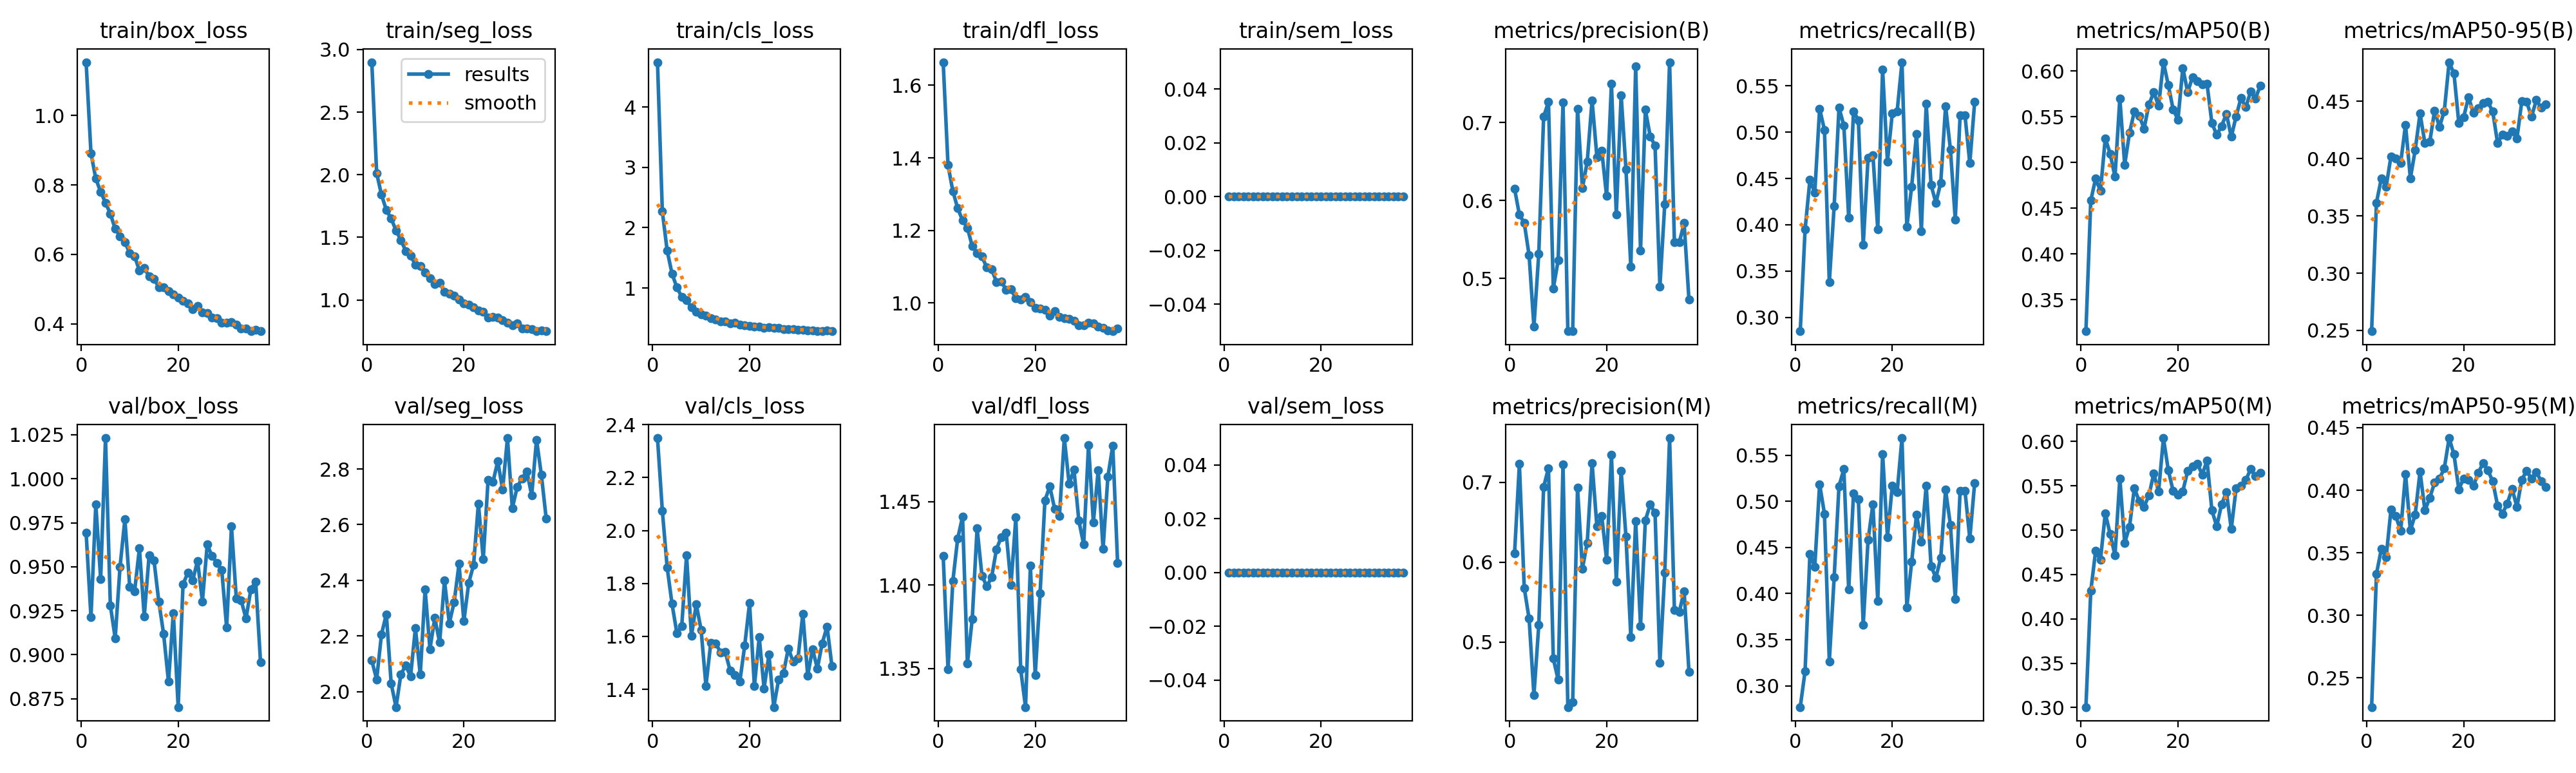

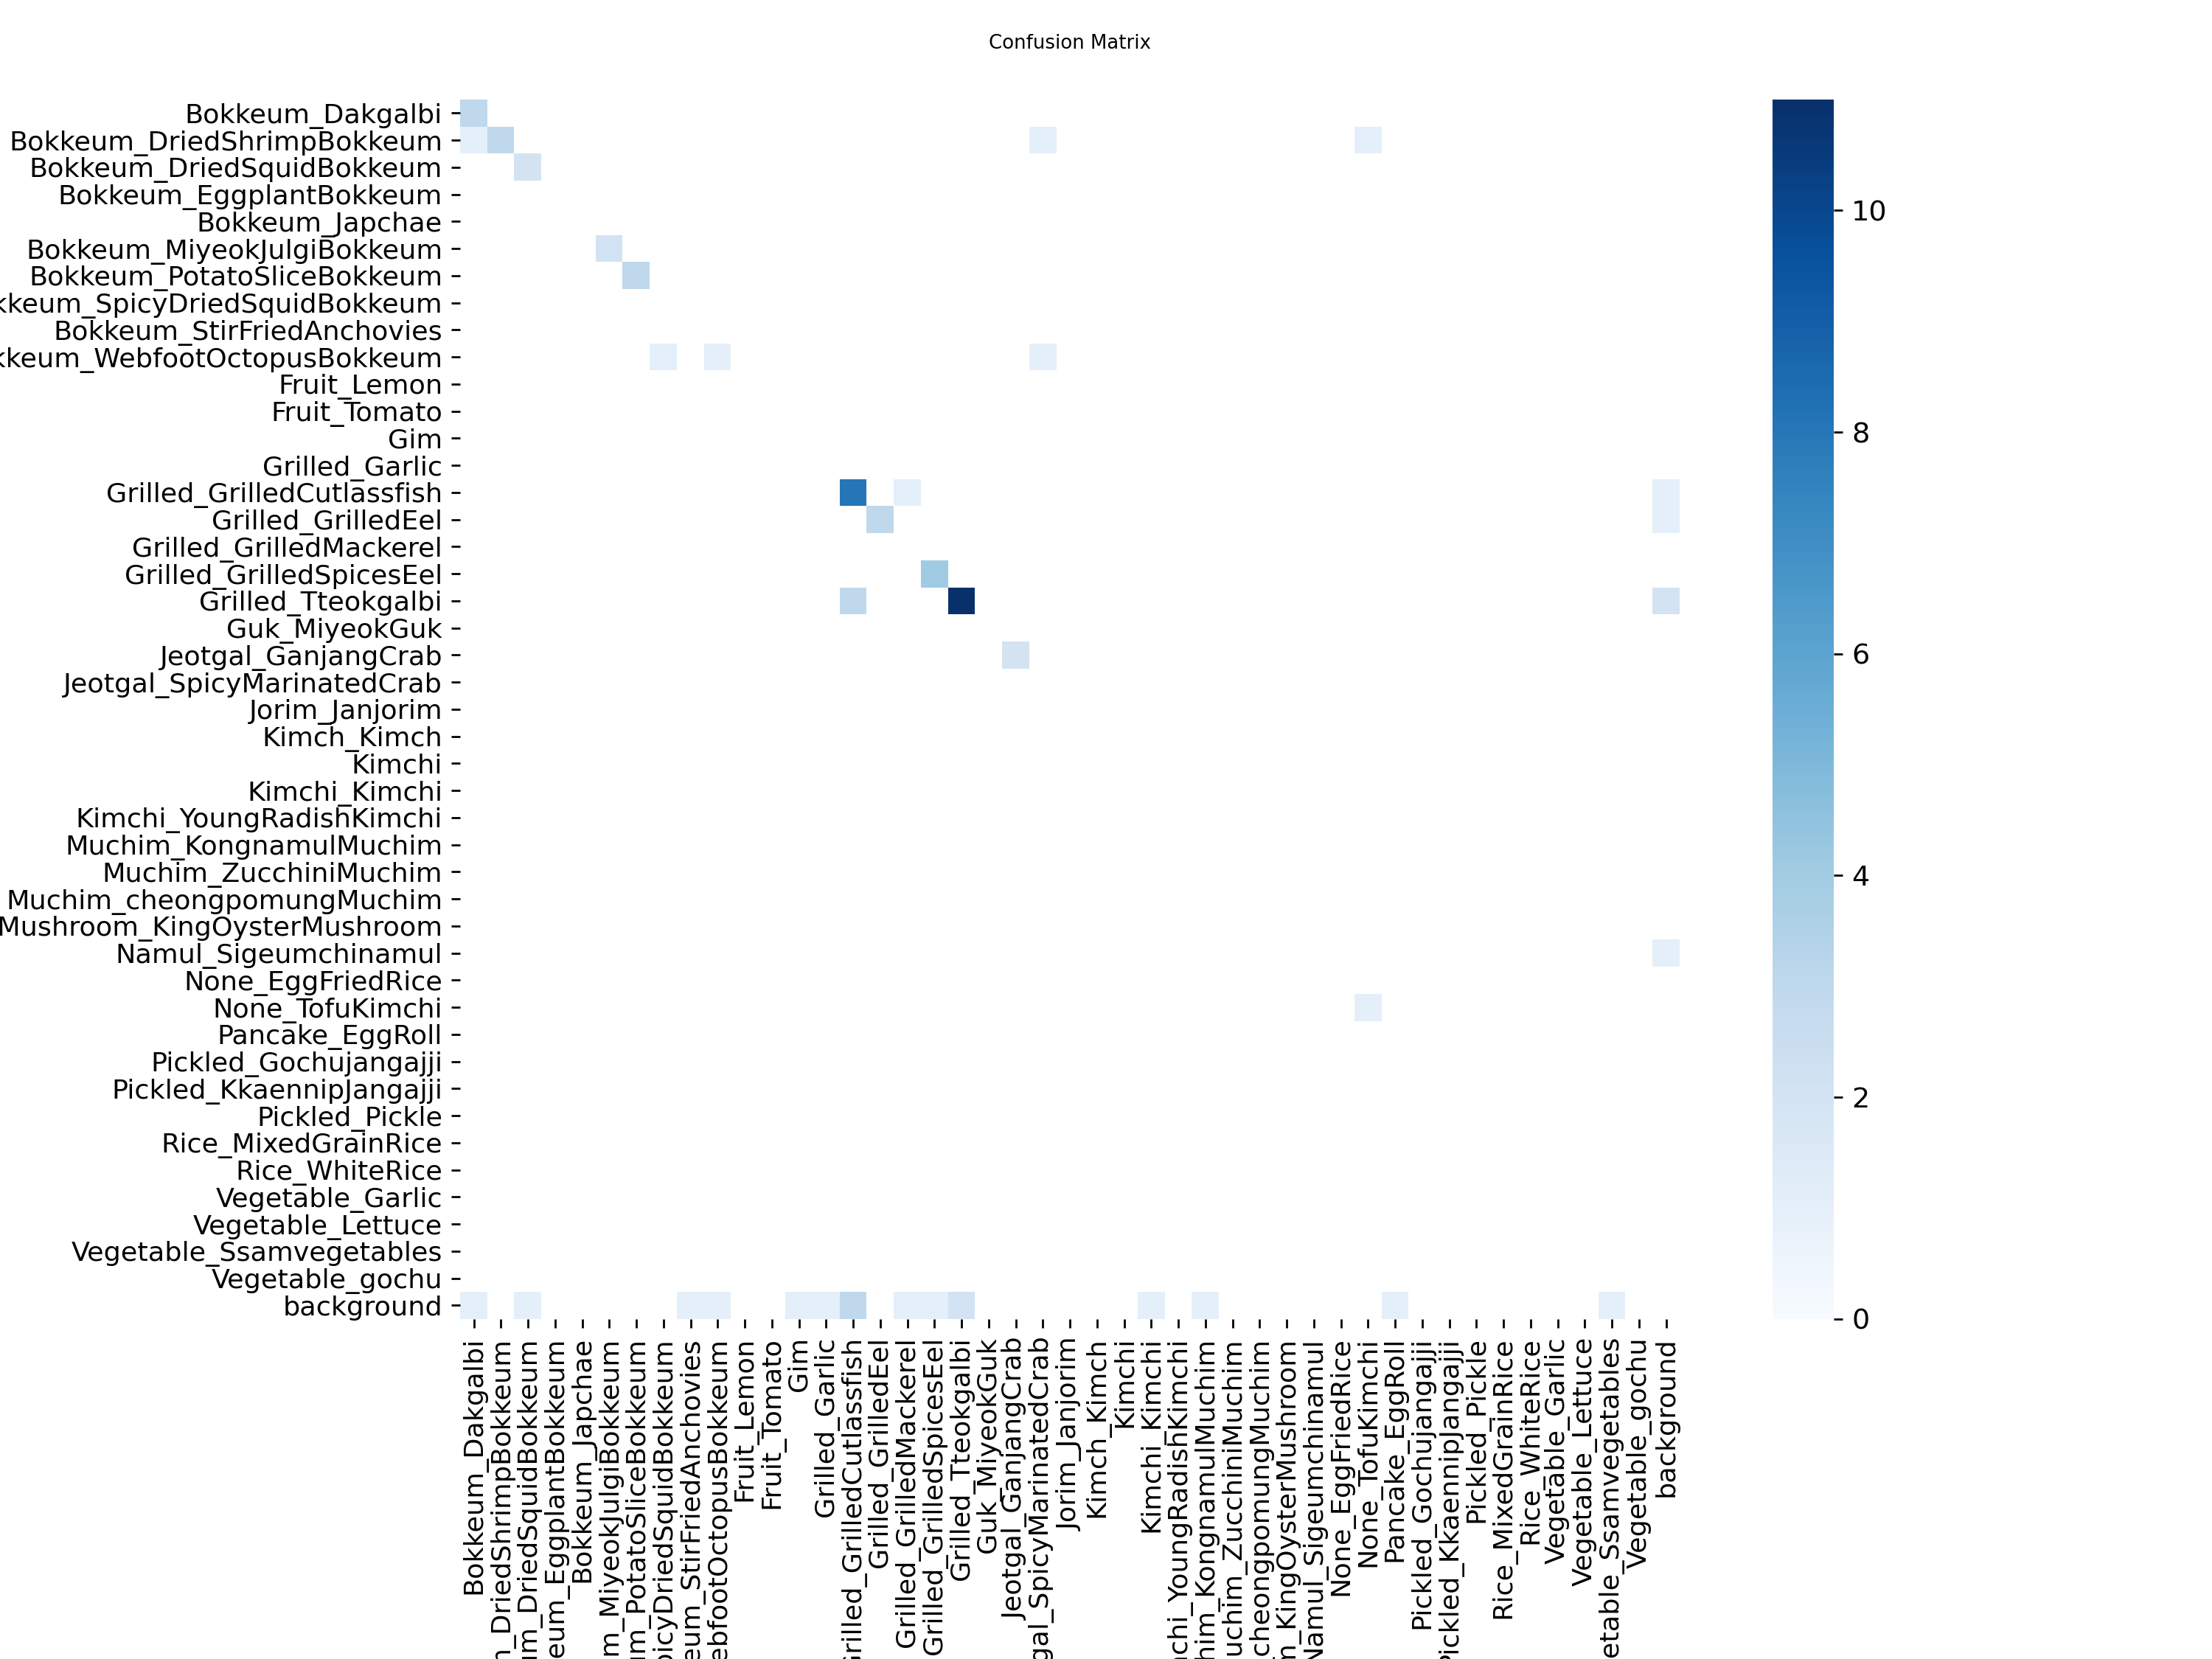

In [8]:
# ================================================================
# 🔥 SCANEAT - 완전 수정 버전 (IndexError 해결)
# ================================================================


# ---------------------------------------------------------------
# [셀 1] GPU 확인
# ---------------------------------------------------------------
!nvidia-smi


# ---------------------------------------------------------------
# [셀 2] 패키지 설치
# ---------------------------------------------------------------
!pip install -q ultralytics albumentations


# ---------------------------------------------------------------
# [셀 3] 드라이브 연결
# ---------------------------------------------------------------
from google.colab import drive
import shutil, os
from ultralytics import YOLO
from IPython.display import Image, display
import glob
from pathlib import Path

drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/MyDrive/scaneat_yolov8'
WORK_DIR   = '/content/scaneat_yolov8'
SAVE_DIR   = '/content/drive/MyDrive/scaneat_results'

if os.path.exists(WORK_DIR):
    shutil.rmtree(WORK_DIR)
shutil.copytree(DRIVE_PATH, WORK_DIR)
os.chdir(WORK_DIR)
print('✅ 작업 디렉토리:', os.getcwd())


# ---------------------------------------------------------------
# [셀 4] 🔥 완전 클린업 (모든 문제 해결!)
# ---------------------------------------------------------------
import yaml

def complete_cleanup(split='train'):
    """데이터 완전 정리"""

    img_dir = Path(f'{WORK_DIR}/{split}/images')
    lbl_dir = Path(f'{WORK_DIR}/{split}/labels')

    if not img_dir.exists() or not lbl_dir.exists():
        return 0, 0

    # 1. data.yaml에서 클래스 수 확인
    yaml_path = f'{WORK_DIR}/data.yaml'
    with open(yaml_path) as f:
        cfg = yaml.safe_load(f)

    nc = cfg['nc']
    print(f"  클래스 수: {nc}")

    img_files = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))

    valid_count = 0
    removed_count = 0

    for img_path in img_files:
        lbl_path = lbl_dir / f'{img_path.stem}.txt'

        # 라벨 없으면 이미지 삭제
        if not lbl_path.exists():
            img_path.unlink()
            removed_count += 1
            continue

        # 라벨 읽기
        try:
            with open(lbl_path) as f:
                lines = f.readlines()

            if not lines:  # 빈 라벨
                img_path.unlink()
                lbl_path.unlink()
                removed_count += 1
                continue

            valid_lines = []
            has_valid = False

            for line in lines:
                parts = line.strip().split()
                if not parts:
                    continue

                try:
                    cls = int(parts[0])
                    coords = list(map(float, parts[1:]))

                    # 클래스 범위 체크
                    if cls < 0 or cls >= nc:
                        continue

                    # Box format (4개)
                    if len(coords) == 4:
                        cx, cy, w, h = coords

                        # 유효성 체크
                        if not (0 <= cx <= 1 and 0 <= cy <= 1 and
                               0 < w <= 1 and 0 < h <= 1):
                            continue

                        # Box → Polygon
                        x1 = max(0.0, min(1.0, cx - w/2))
                        y1 = max(0.0, min(1.0, cy - h/2))
                        x2 = max(0.0, min(1.0, cx + w/2))
                        y2 = max(0.0, min(1.0, cy + h/2))

                        # 최소 크기 체크
                        if (x2 - x1) < 0.01 or (y2 - y1) < 0.01:
                            continue

                        valid_lines.append(
                            f"{cls} {x1:.6f} {y1:.6f} {x2:.6f} {y1:.6f} "
                            f"{x2:.6f} {y2:.6f} {x1:.6f} {y2:.6f}"
                        )
                        has_valid = True

                    # Polygon (8개 이상)
                    elif len(coords) >= 8 and len(coords) % 2 == 0:
                        # 모든 좌표 체크
                        valid = all(
                            0 <= coords[i] <= 1
                            for i in range(len(coords))
                        )

                        if valid:
                            valid_lines.append(line.strip())
                            has_valid = True

                except:
                    continue

            # 유효한 라벨이 있으면 저장, 없으면 삭제
            if has_valid and valid_lines:
                lbl_path.write_text('\n'.join(valid_lines) + '\n')
                valid_count += 1
            else:
                img_path.unlink()
                lbl_path.unlink()
                removed_count += 1

        except Exception as e:
            # 에러 나면 삭제
            img_path.unlink()
            if lbl_path.exists():
                lbl_path.unlink()
            removed_count += 1

    return valid_count, removed_count


print("\n" + "="*70)
print("🧹 데이터 완전 클린업")
print("="*70)

total_valid = 0
total_removed = 0

for split in ['train', 'valid', 'test']:
    valid, removed = complete_cleanup(split)
    total_valid += valid
    total_removed += removed
    print(f"{split:10s}: 유효 {valid}장, 제거 {removed}장")

print(f"\n총계: 유효 {total_valid}장, 제거 {total_removed}장")
print("="*70)

# 캐시 완전 삭제
for cache in glob.glob('**/*.cache', recursive=True):
    os.remove(cache)
    print(f"  캐시 삭제: {cache}")

print('✅ 클린업 완료!')


# ---------------------------------------------------------------
# [셀 5] 간단한 증강 (안전 버전)
# ---------------------------------------------------------------
import cv2
import numpy as np
from tqdm.auto import tqdm

def safe_augment(split='train', n_aug=2):
    """안전한 증강 (복잡한 transform 제거)"""

    img_dir = Path(f'{WORK_DIR}/{split}/images')
    lbl_dir = Path(f'{WORK_DIR}/{split}/labels')

    aug_img_dir = Path(f'{WORK_DIR}/{split}_aug/images')
    aug_lbl_dir = Path(f'{WORK_DIR}/{split}_aug/labels')

    aug_img_dir.mkdir(parents=True, exist_ok=True)
    aug_lbl_dir.mkdir(parents=True, exist_ok=True)

    img_files = list(img_dir.glob('*.jpg'))

    print(f"\n{split} 증강 중...")

    for img_path in tqdm(img_files):
        lbl_path = lbl_dir / f'{img_path.stem}.txt'

        if not lbl_path.exists():
            continue

        # 원본 복사
        shutil.copy(img_path, aug_img_dir / img_path.name)
        shutil.copy(lbl_path, aug_lbl_dir / lbl_path.name)

        # 간단한 증강만 (Flip, Brightness)
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        with open(lbl_path) as f:
            labels = f.read()

        # 1. 좌우 반전
        if np.random.random() > 0.5:
            img_flip = cv2.flip(img, 1)

            aug_name = f"{img_path.stem}_flip"
            cv2.imwrite(str(aug_img_dir / f"{aug_name}.jpg"), img_flip)

            # 라벨도 반전 (x 좌표만)
            lines = []
            for line in labels.strip().split('\n'):
                parts = line.split()
                if len(parts) >= 5:
                    cls = parts[0]
                    coords = [float(x) for x in parts[1:]]

                    # x 좌표 반전
                    for i in range(0, len(coords), 2):
                        coords[i] = 1.0 - coords[i]

                    lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in coords)}")

            with open(aug_lbl_dir / f"{aug_name}.txt", 'w') as f:
                f.write('\n'.join(lines) + '\n')

        # 2. 밝기 조정
        if np.random.random() > 0.5:
            factor = np.random.uniform(0.7, 1.3)
            img_bright = np.clip(img * factor, 0, 255).astype(np.uint8)

            aug_name = f"{img_path.stem}_bright"
            cv2.imwrite(str(aug_img_dir / f"{aug_name}.jpg"), img_bright)
            shutil.copy(lbl_path, aug_lbl_dir / f"{aug_name}.txt")

    total = len(list(aug_img_dir.glob('*.jpg')))
    print(f"✅ {split}: {total}장 (원본 포함)")


safe_augment('train', n_aug=2)


# ---------------------------------------------------------------
# [셀 6] data.yaml 수정
# ---------------------------------------------------------------
yaml_path = f'{WORK_DIR}/data.yaml'

with open(yaml_path) as f:
    cfg = yaml.safe_load(f)

cfg['path'] = WORK_DIR
cfg['train'] = 'train_aug/images'
cfg['val'] = 'valid/images'
cfg['test'] = 'test/images'

with open(yaml_path, 'w') as f:
    yaml.dump(cfg, f)

print('✅ data.yaml 수정')


# ---------------------------------------------------------------
# [셀 7] 🔥 학습 (안전 설정)
# ---------------------------------------------------------------
model = YOLO('yolov8s-seg.pt')

results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,
    batch=8,          # 줄임!
    device=0,
    project=SAVE_DIR,
    name='food_seg_safe',
    exist_ok=True,
    patience=20,
    workers=2,        # 줄임!

    # 최소 증강 (안전)
    degrees=10.0,
    translate=0.05,
    scale=0.3,
    fliplr=0.5,
    flipud=0.0,
    mosaic=0.0,      # 끔!
    mixup=0.0,       # 끔!
    copy_paste=0.0,  # 끔!
    hsv_h=0.01,
    hsv_s=0.3,
    hsv_v=0.2,

    freeze=10,
    augment=True,
    cache=False,      # 추가!
)

print('✅ 학습 완료!')
print(f'모델: {SAVE_DIR}/food_seg_safe/weights/best.pt')


# ---------------------------------------------------------------
# [셀 8] 결과 확인
# ---------------------------------------------------------------
result_dir = f'{SAVE_DIR}/food_seg_safe'

if os.path.exists(f'{result_dir}/results.png'):
    display(Image(filename=f'{result_dir}/results.png'))

if os.path.exists(f'{result_dir}/confusion_matrix.png'):
    display(Image(filename=f'{result_dir}/confusion_matrix.png'))

Ultralytics 8.4.17 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/scaneat_yolov8/data.yaml, degrees=20.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.03, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=food_seg_proper, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, 

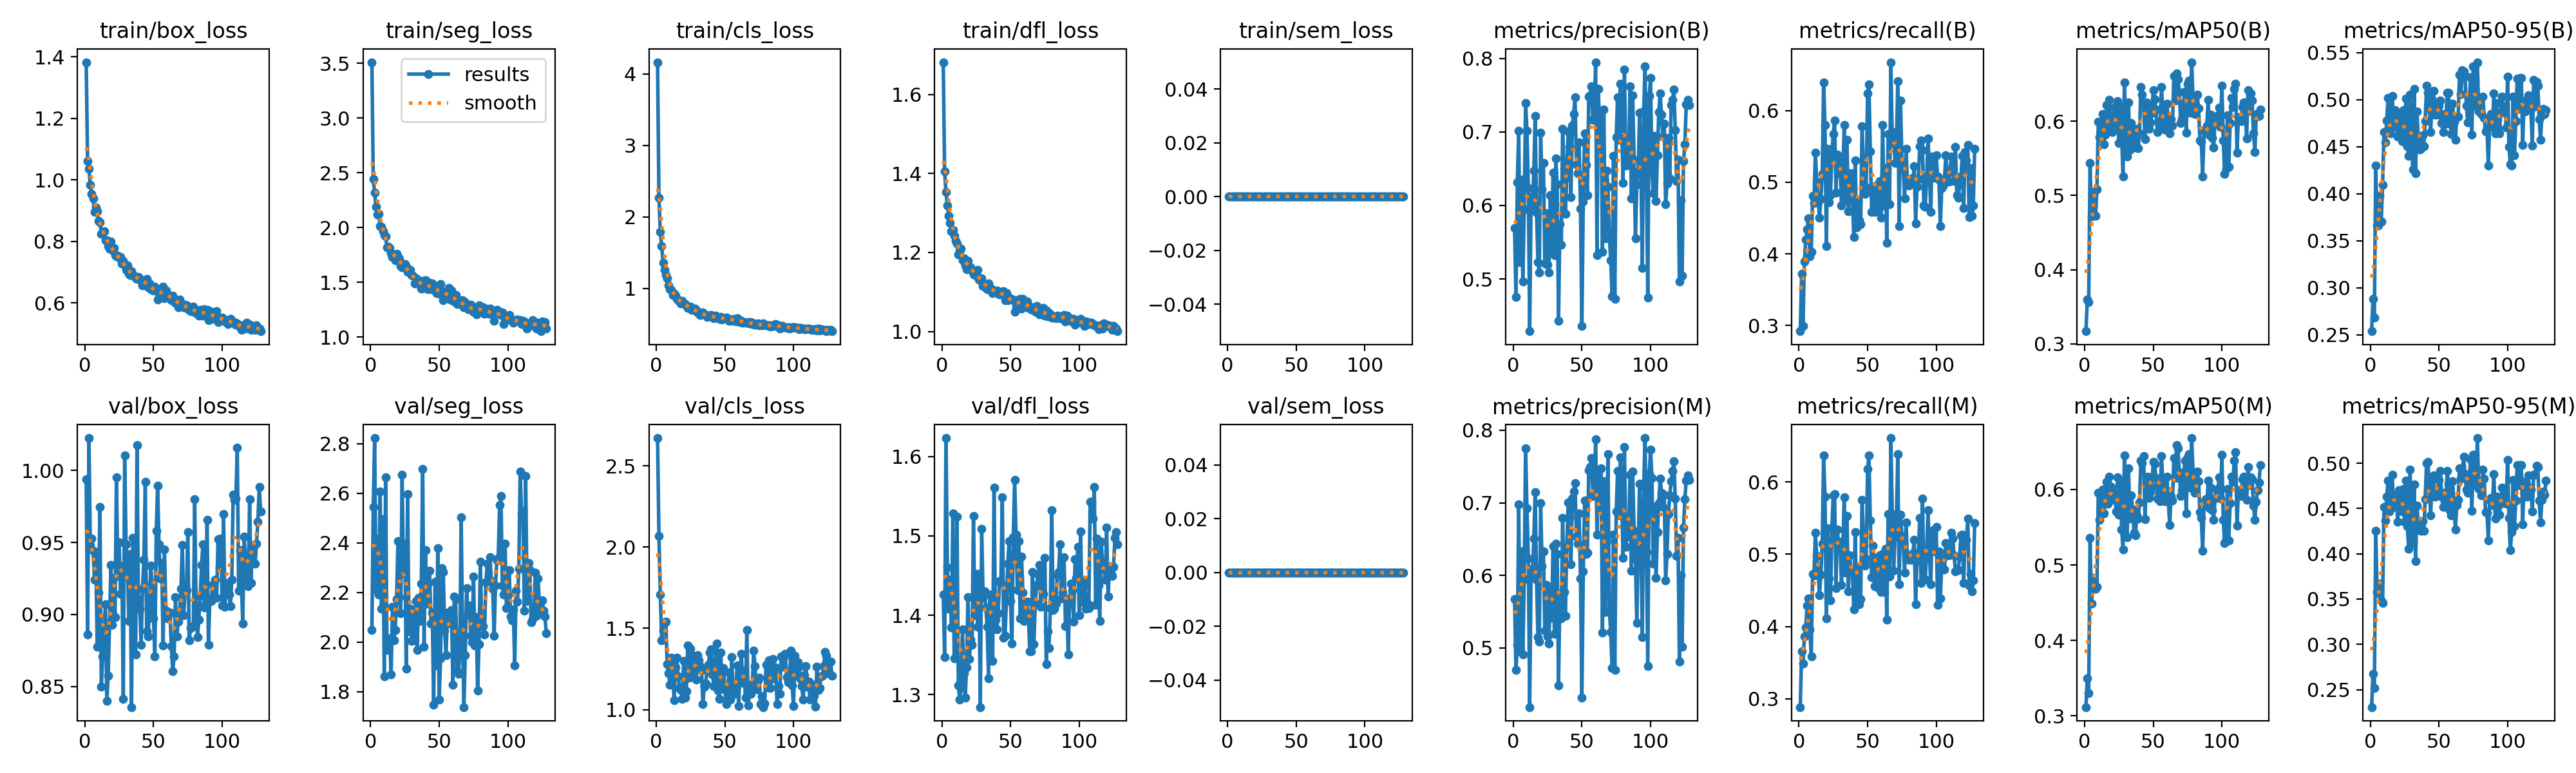

✅ results.png


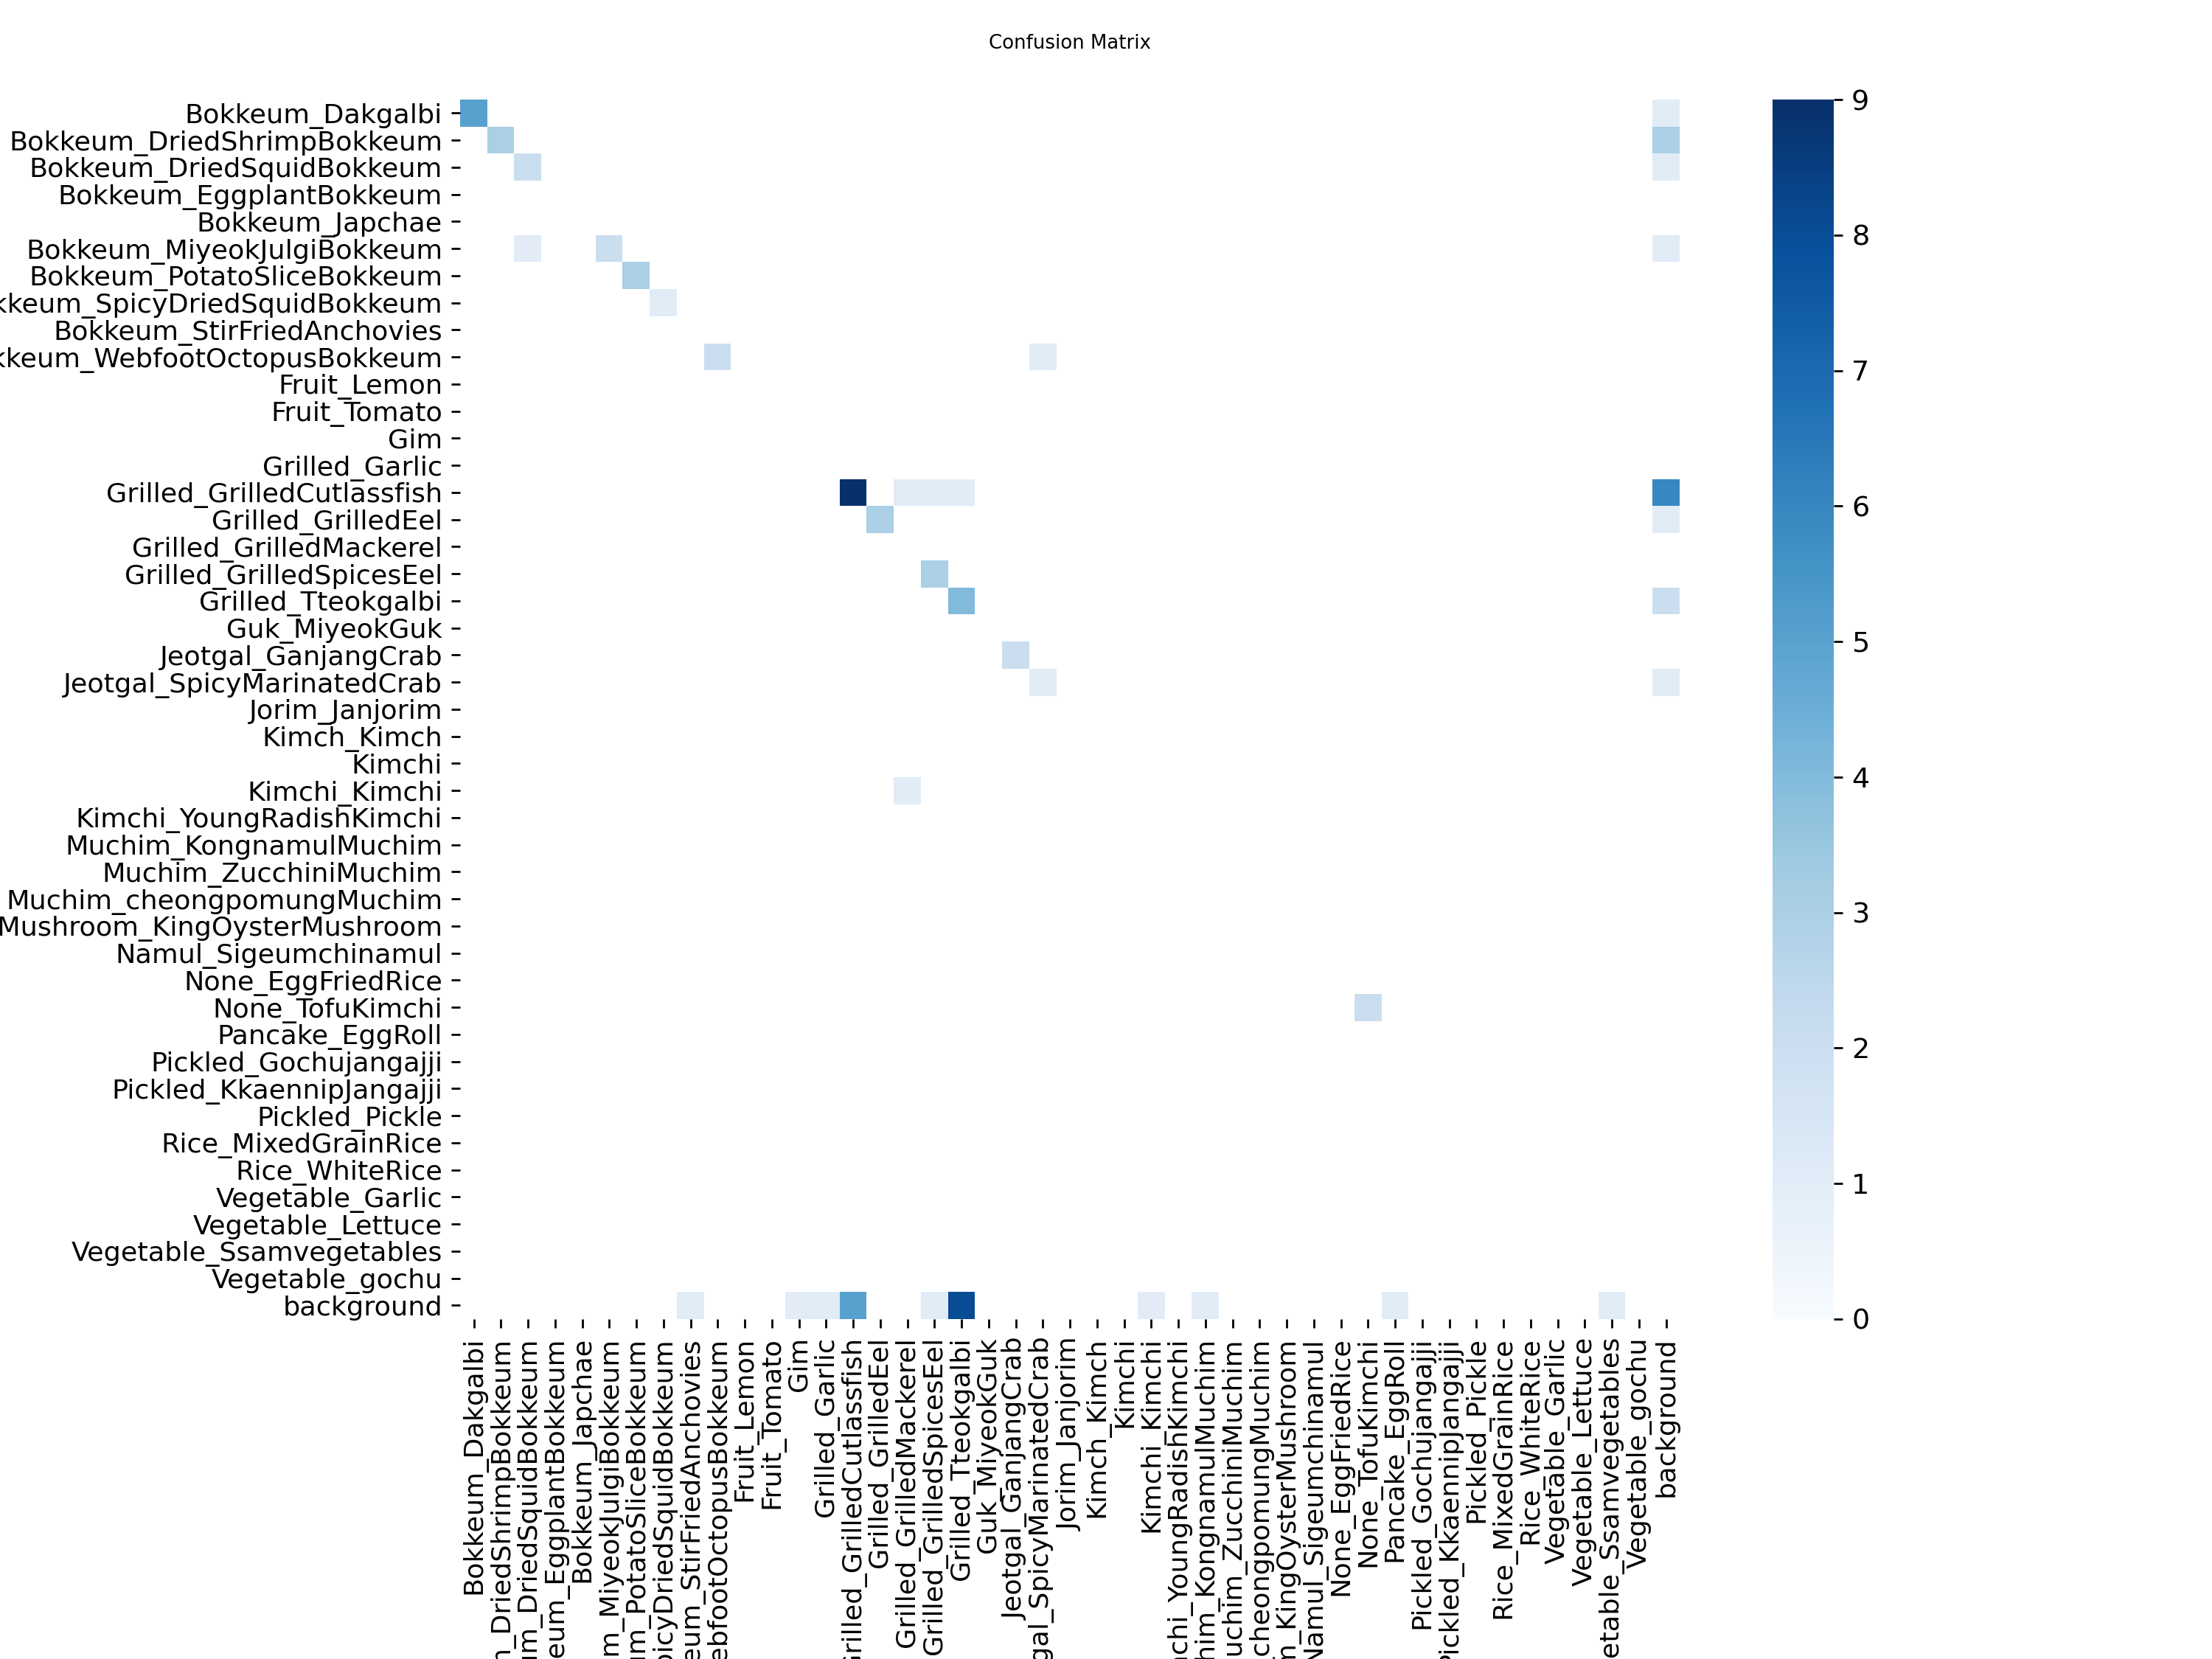

✅ confusion_matrix.png


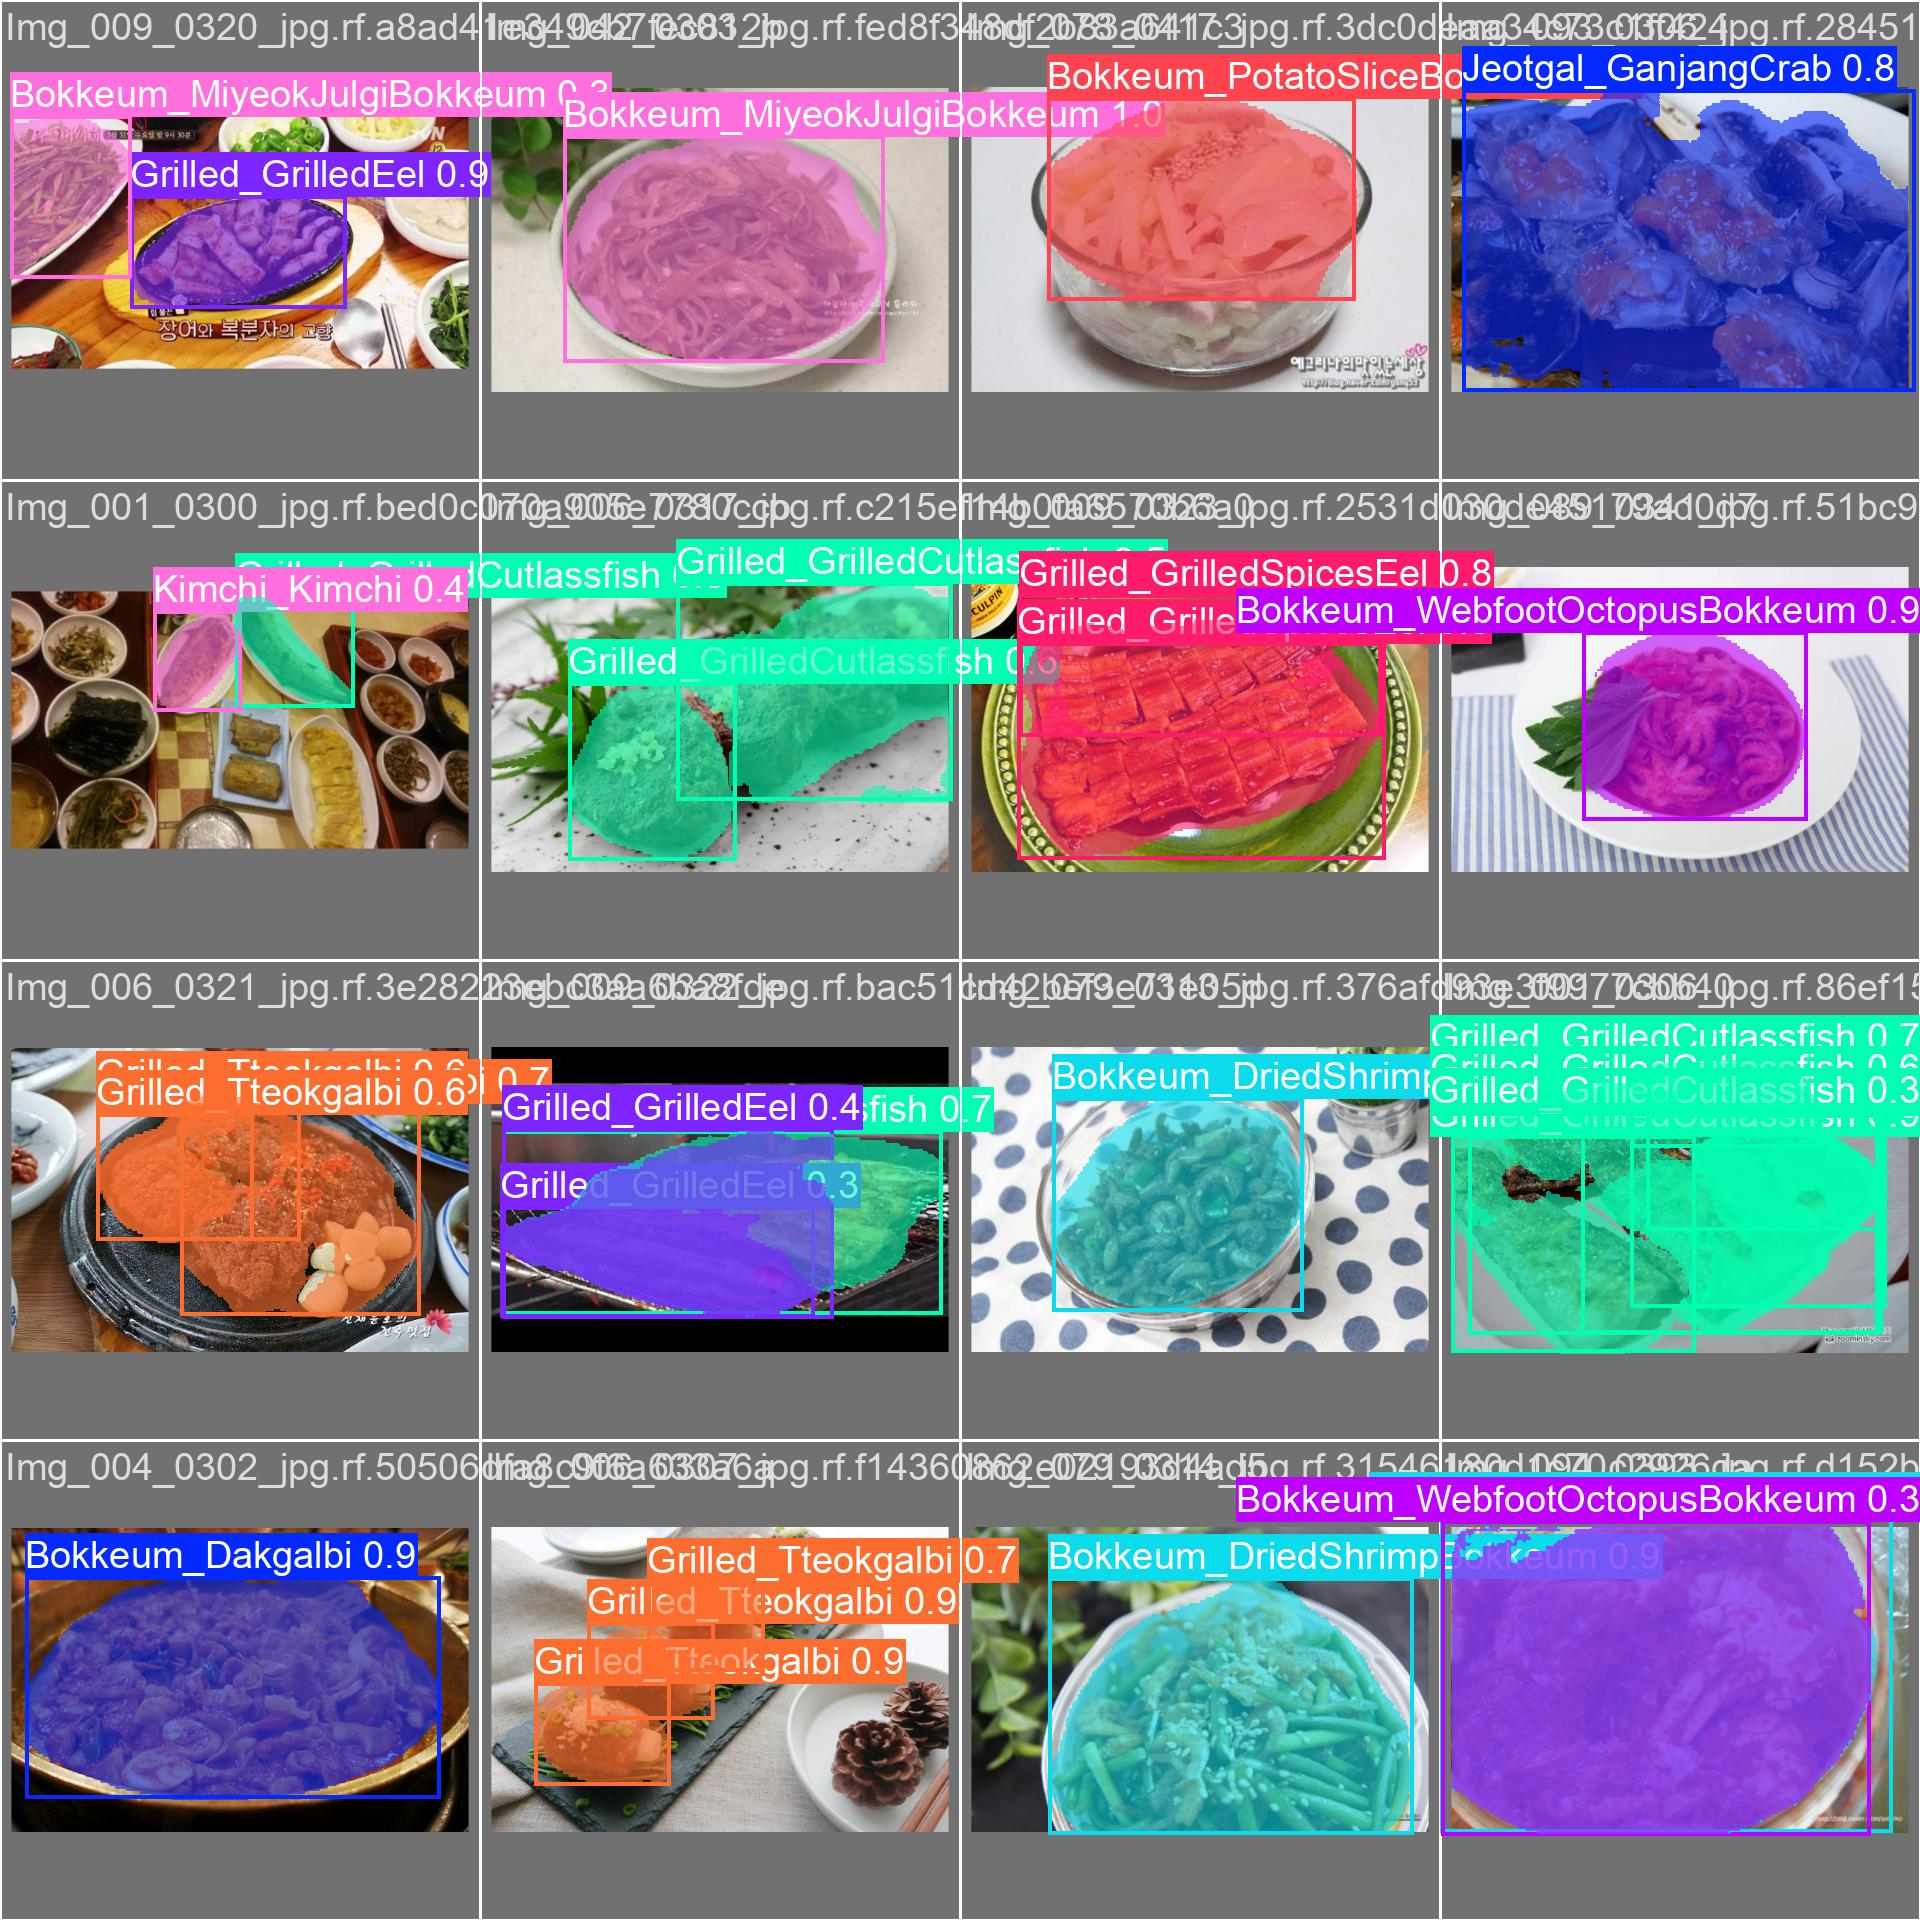

✅ val_batch0_pred.jpg


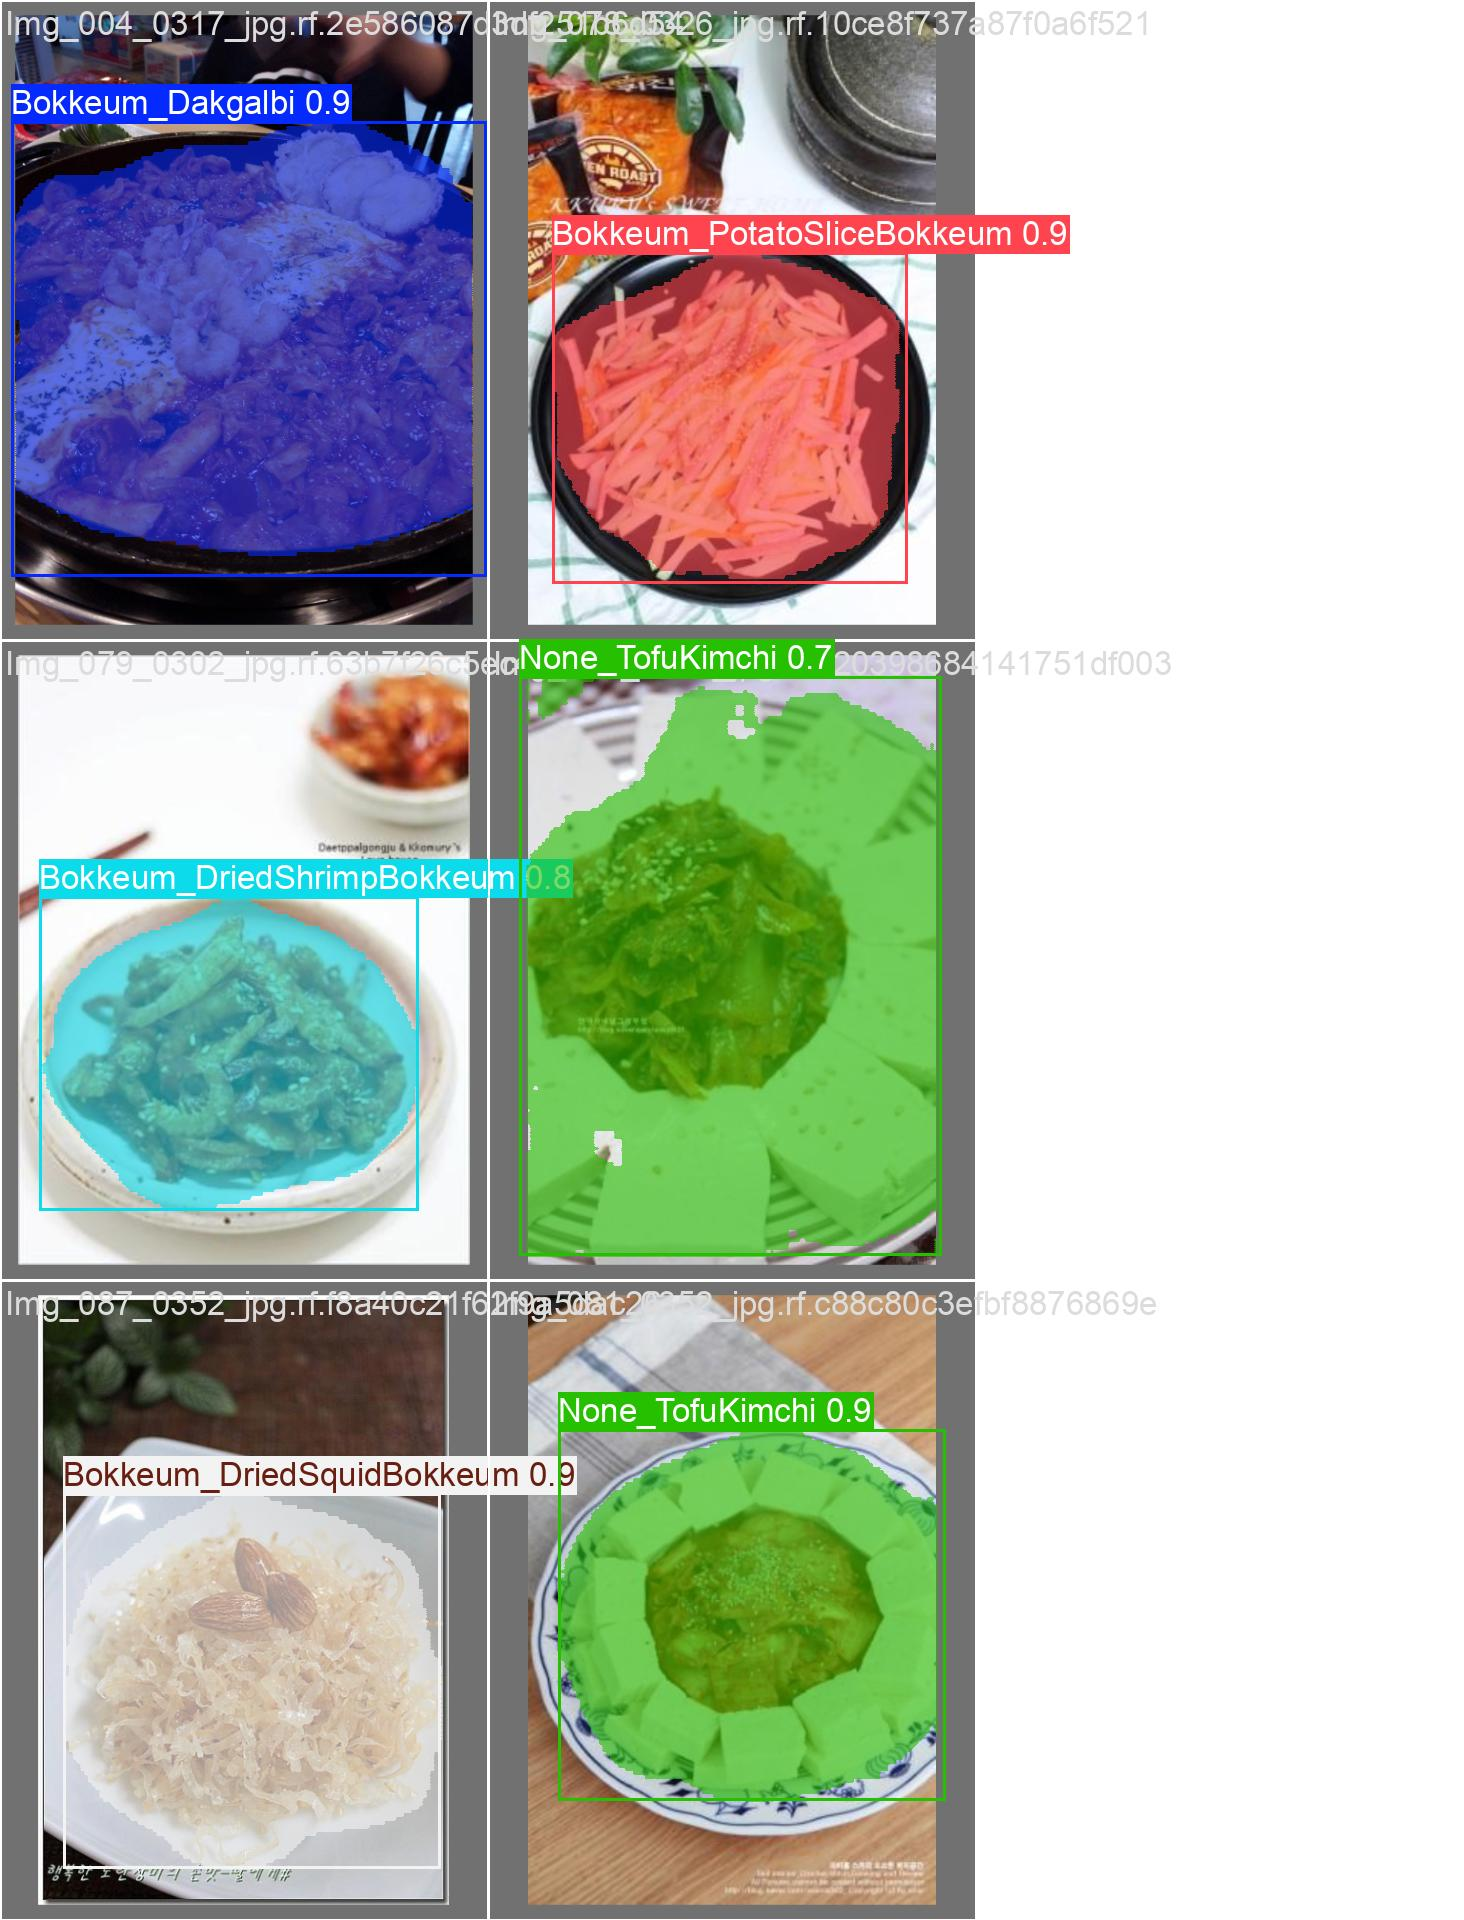

✅ val_batch1_pred.jpg

🔮 테스트 추론 (38장)

image 1/1 /content/scaneat_yolov8/valid/images/Img_001_0306_jpg.rf.86ef15c10cab31e15d578b50073c7a06.jpg: 448x640 4 Grilled_GrilledCutlassfishs, 72.2ms
Speed: 5.1ms preprocess, 72.2ms inference, 24.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/test_output/result_0

이미지 1: Img_001_0306_jpg.rf.86ef15c10cab31e15d578b50073c7a06.jpg
  🍽️ Grilled_GrilledCutlassfish     | 90.90%
  🍽️ Grilled_GrilledCutlassfish     | 77.24%
  🍽️ Grilled_GrilledCutlassfish     | 75.67%
  🍽️ Grilled_GrilledCutlassfish     | 46.08%


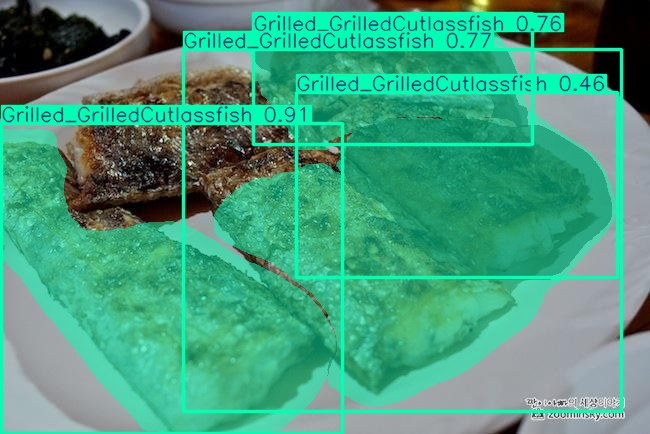


image 1/1 /content/scaneat_yolov8/valid/images/Img_078_0417_jpg.rf.3dc0deaa34c73c1ff4249eb6f5eaf059.jpg: 448x640 1 Bokkeum_PotatoSliceBokkeum, 10.5ms
Speed: 6.8ms preprocess, 10.5ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/test_output/result_1

이미지 2: Img_078_0417_jpg.rf.3dc0deaa34c73c1ff4249eb6f5eaf059.jpg
  🍽️ Bokkeum_PotatoSliceBokkeum     | 88.46%


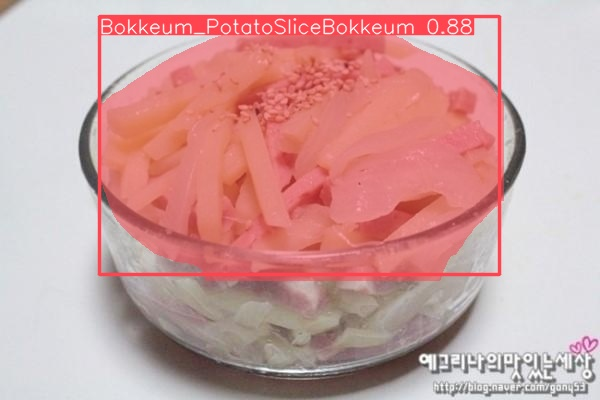


image 1/1 /content/scaneat_yolov8/valid/images/Img_001_0300_jpg.rf.bed0c070a905e7780ccb6e5992ba978b.jpg: 384x640 1 Grilled_GrilledCutlassfish, 1 Kimchi_Kimchi, 1 Pancake_EggRoll, 93.2ms
Speed: 3.6ms preprocess, 93.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/test_output/result_2

이미지 3: Img_001_0300_jpg.rf.bed0c070a905e7780ccb6e5992ba978b.jpg
  🍽️ Grilled_GrilledCutlassfish     | 86.69%
  🍽️ Pancake_EggRoll                | 43.95%
  🍽️ Kimchi_Kimchi                  | 28.47%


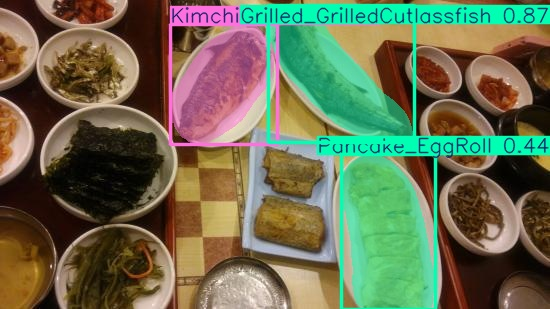


image 1/1 /content/scaneat_yolov8/valid/images/Img_089_0326_jpg.rf.c323f95a5f4112418dc161c8dd4b494b.jpg: 480x640 1 Bokkeum_WebfootOctopusBokkeum, 1 Grilled_GrilledSpicesEel, 88.7ms
Speed: 4.5ms preprocess, 88.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/test_output/result_3

이미지 4: Img_089_0326_jpg.rf.c323f95a5f4112418dc161c8dd4b494b.jpg
  🍽️ Grilled_GrilledSpicesEel       | 84.63%
  🍽️ Bokkeum_WebfootOctopusBokkeum  | 26.74%


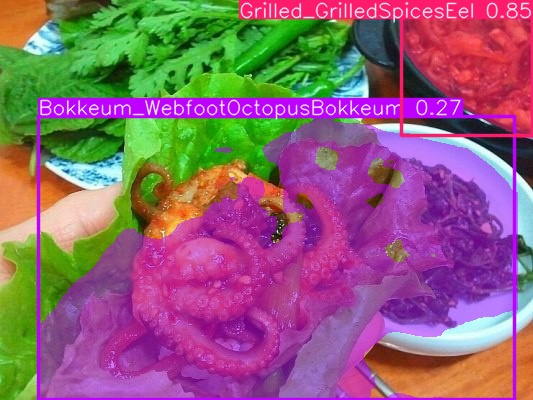


image 1/1 /content/scaneat_yolov8/valid/images/Img_094_0393_jpg.rf.d152b08f061b42757444596d5bf597e8.jpg: 448x640 1 Jeotgal_SpicyMarinatedCrab, 11.6ms
Speed: 3.2ms preprocess, 11.6ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/test_output/result_4

이미지 5: Img_094_0393_jpg.rf.d152b08f061b42757444596d5bf597e8.jpg
  🍽️ Jeotgal_SpicyMarinatedCrab     | 81.04%


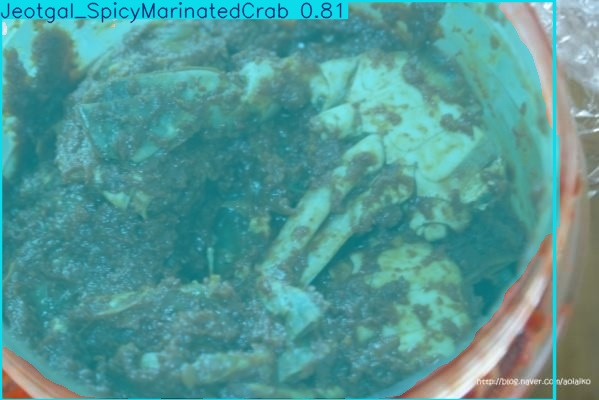

Ultralytics 8.4.17 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1832.1±1037.6 MB/s, size: 116.9 KB)
val: Scanning /content/scaneat_yolov8/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 38/38 15.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 38/38 15.4it/s 2.5s
                   all         38         69      0.583      0.578      0.655      0.528      0.583      0.578      0.647      0.521
      Bokkeum_Dakgalbi          5          5      0.755          1      0.928       0.84      0.755          1      0.928      0.865
Bokkeum_DriedShrimpBokkeum          3          3      0.668          1      0.995       0.83      0.668          1      0.995      0.852
Bokkeum_DriedSquidBokkeum          3          3          1      0.946      0.995      0.825          1      0.946      0

In [9]:
# ---------------------------------------------------------------
# [셀 7] 🔥 제대로 된 학습 설정
# ---------------------------------------------------------------
from ultralytics import YOLO

model = YOLO('yolov8s-seg.pt')

results = model.train(
    data=yaml_path,

    # ============================================
    # 📊 학습 설정 (소규모 데이터 최적화)
    # ============================================
    epochs=200,         # 늘림! (100 → 200)
    patience=50,        # 늘림! (20 → 50)
    imgsz=640,
    batch=16,           # 늘림! (8 → 16)
    device=0,
    workers=4,          # 늘림! (2 → 4)

    project=SAVE_DIR,
    name='food_seg_proper',
    exist_ok=True,
    save=True,
    plots=True,
    cache=False,

    # ============================================
    # 🎨 강력한 증강 (데이터 부족 해결!)
    # ============================================

    # Geometric
    degrees=20.0,       # 늘림! (10 → 20)
    translate=0.1,      # 늘림! (0.05 → 0.1)
    scale=0.5,          # 늘림! (0.3 → 0.5)
    shear=5.0,          # 추가!
    perspective=0.0001, # 추가!
    flipud=0.0,
    fliplr=0.5,

    # Color (음식 중요!)
    hsv_h=0.03,         # 늘림! (0.01 → 0.03)
    hsv_s=0.7,          # 늘림! (0.3 → 0.7)
    hsv_v=0.4,          # 늘림! (0.2 → 0.4)

    # Advanced (다시 켬!)
    mosaic=1.0,         # 켬! (0 → 1.0) 중요!
    mixup=0.1,          # 켬! (0 → 0.1)
    copy_paste=0.2,     # 켬! (0 → 0.2)

    # ============================================
    # 🔧 학습 최적화
    # ============================================
    freeze=0,           # Freeze 해제! (10 → 0)
    lr0=0.001,          # Learning rate 조정
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,

    # Dropout (overfitting 방지)
    dropout=0.0,

    # Augmentation
    augment=True,
    auto_augment='randaugment',
    erasing=0.4,

    # Validation
    val=True,
    split='val',
    save_period=10,     # 10 epoch마다 저장

    # 기타
    overlap_mask=True,  # 변경!
    mask_ratio=4,
    retina_masks=False,

    # Optimization
    amp=True,
    close_mosaic=10,

    # Verbose
    verbose=True,
)

print('\n' + '='*70)
print('✅ 학습 완료!')
print('='*70)
print(f'모델: {SAVE_DIR}/food_seg_proper/weights/best.pt')
print('='*70)


# ---------------------------------------------------------------
# [셀 8] 학습 결과 분석
# ---------------------------------------------------------------
result_dir = f'{SAVE_DIR}/food_seg_proper'

print("\n📊 학습 결과 시각화")
print("="*70)

# Results
if os.path.exists(f'{result_dir}/results.png'):
    display(Image(filename=f'{result_dir}/results.png'))
    print("✅ results.png")

# Confusion Matrix
if os.path.exists(f'{result_dir}/confusion_matrix.png'):
    display(Image(filename=f'{result_dir}/confusion_matrix.png'))
    print("✅ confusion_matrix.png")

# Validation Predictions
for i in range(3):
    pred_file = f'{result_dir}/val_batch{i}_pred.jpg'
    if os.path.exists(pred_file):
        display(Image(filename=pred_file))
        print(f"✅ val_batch{i}_pred.jpg")

# F1 Curve
if os.path.exists(f'{result_dir}/F1_curve.png'):
    display(Image(filename=f'{result_dir}/F1_curve.png'))
    print("✅ F1_curve.png")

# PR Curve
if os.path.exists(f'{result_dir}/PR_curve.png'):
    display(Image(filename=f'{result_dir}/PR_curve.png'))
    print("✅ PR_curve.png")


# ---------------------------------------------------------------
# [셀 9] 테스트 추론
# ---------------------------------------------------------------
model = YOLO(f'{SAVE_DIR}/food_seg_proper/weights/best.pt')

# Valid 이미지로 테스트
test_imgs = list(Path(f'{WORK_DIR}/valid/images').glob('*.jpg'))

if test_imgs:
    print(f"\n🔮 테스트 추론 ({len(test_imgs)}장)")

    # 여러 장 테스트
    for i, test_img in enumerate(test_imgs[:5]):  # 처음 5장
        results = model.predict(
            source=str(test_img),
            conf=0.25,
            iou=0.5,
            save=True,
            project='/content/test_output',
            name=f'result_{i}',
            exist_ok=True,
        )

        # 결과 출력
        for r in results:
            print(f"\n이미지 {i+1}: {test_img.name}")
            if len(r.boxes) > 0:
                for box in r.boxes:
                    cls_name = model.names[int(box.cls)]
                    conf = float(box.conf)
                    print(f"  🍽️ {cls_name:30s} | {conf:.2%}")
            else:
                print("  ⚠️ 검출 없음")

        # 이미지 표시
        output = list(Path(f'/content/test_output/result_{i}').glob('*.jpg'))
        if output:
            display(Image(filename=str(output[0])))


# ---------------------------------------------------------------
# [셀 10] 성능 분석
# ---------------------------------------------------------------
def analyze_performance():
    """성능 상세 분석"""

    # 검증 재실행
    metrics = model.val(
        data=yaml_path,
        split='val',
        batch=1,
        conf=0.001,
        iou=0.6,
        plots=True,
    )

    print("\n" + "="*70)
    print("📊 상세 성능 분석")
    print("="*70)

    # Box Detection
    print("\n[Box Detection]")
    print(f"  mAP@50:    {metrics.box.map50:.3f}")
    print(f"  mAP@50-95: {metrics.box.map:.3f}")
    print(f"  Precision: {metrics.box.mp:.3f}")
    print(f"  Recall:    {metrics.box.mr:.3f}")

    # Segmentation
    print("\n[Segmentation]")
    print(f"  mAP@50:    {metrics.seg.map50:.3f}")
    print(f"  mAP@50-95: {metrics.seg.map:.3f}")
    print(f"  Precision: {metrics.seg.mp:.3f}")
    print(f"  Recall:    {metrics.seg.mr:.3f}")

    # 클래스별 성능 (낮은 것만)
    print("\n[성능 낮은 클래스 (mAP50 < 0.5)]")

    for i, name in enumerate(model.names.values()):
        map50 = metrics.box.maps[i]
        if map50 < 0.5:
            print(f"  {name:30s}: {map50:.3f}")

    print("="*70)

analyze_performance()


# ---------------------------------------------------------------
# [셀 11] 데이터셋 통계
# ---------------------------------------------------------------
def print_dataset_stats():
    """데이터셋 상세 통계"""

    import yaml
    from collections import Counter

    print("\n" + "="*70)
    print("📊 데이터셋 통계")
    print("="*70)

    for split in ['train_aug', 'valid', 'test']:
        img_dir = Path(f'{WORK_DIR}/{split}/images')
        lbl_dir = Path(f'{WORK_DIR}/{split}/labels')

        if not img_dir.exists():
            continue

        imgs = list(img_dir.glob('*.jpg'))

        # 클래스 분포
        class_counts = Counter()

        for img in imgs:
            lbl = lbl_dir / f'{img.stem}.txt'
            if lbl.exists():
                with open(lbl) as f:
                    for line in f:
                        parts = line.strip().split()
                        if parts:
                            cls = int(parts[0])
                            class_counts[cls] += 1

        print(f"\n[{split.upper()}]")
        print(f"  이미지: {len(imgs)}장")
        print(f"  객체:   {sum(class_counts.values())}개")
        print(f"  클래스: {len(class_counts)}개")

        # 가장 적은 클래스
        if class_counts:
            min_cls = min(class_counts, key=class_counts.get)
            min_count = class_counts[min_cls]
            print(f"  최소:   {model.names[min_cls]} ({min_count}개)")

    print("="*70)

print_dataset_stats()

In [ ]:
# ================================================================
# 🔥 SCANEAT - Fine-tuning
# 이미 학습된 모델을 더 정밀하게 튜닝
# ================================================================


# ---------------------------------------------------------------
# [셀 1] Fine-tuning 전략 설정
# ---------------------------------------------------------------
from ultralytics import YOLO
from pathlib import Path
import os

# 이미 학습된 모델 로드
BEST_MODEL = '/content/drive/MyDrive/scaneat_results/food_seg_proper/weights/best.pt'
SAVE_DIR = '/content/drive/MyDrive/scaneat_results'
WORK_DIR = '/content/scaneat_yolov8'

model = YOLO(BEST_MODEL)

print("="*70)
print("🎯 FINE-TUNING STRATEGY")
print("="*70)
print(f"Base Model: {BEST_MODEL}")
print(f"Current mAP50: 0.679 (Box), 0.668 (Mask)")
print(f"Target: 0.75+ (10% improvement)")
print("="*70)


# ---------------------------------------------------------------
# [셀 2] 옵션 1: 학습률 감소 + 긴 학습 (추천!)
# ---------------------------------------------------------------
results_lr = model.train(
    data=f'{WORK_DIR}/data.yaml',

    # ============================================
    # 📚 Fine-tuning 설정
    # ============================================
    epochs=100,          # 추가 100 epoch
    patience=30,
    imgsz=640,
    batch=16,
    device=0,

    project=SAVE_DIR,
    name='food_seg_finetune_lr',
    exist_ok=True,

    # ============================================
    # 🔧 낮은 Learning Rate (핵심!)
    # ============================================
    lr0=0.0001,          # 10배 감소! (0.001 → 0.0001)
    lrf=0.001,           # 최종 LR도 감소
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=0,     # Warmup 제거 (이미 학습됨)

    # ============================================
    # 🎨 증강 유지 (강하게)
    # ============================================
    degrees=20.0,
    translate=0.1,
    scale=0.5,
    shear=5.0,
    perspective=0.0001,
    fliplr=0.5,
    flipud=0.0,

    hsv_h=0.03,
    hsv_s=0.7,
    hsv_v=0.4,

    mosaic=1.0,
    mixup=0.1,
    copy_paste=0.2,

    # ============================================
    # 기타
    # ============================================
    freeze=0,
    augment=True,
    auto_augment='randaugment',
    erasing=0.4,

    overlap_mask=True,
    amp=True,
    close_mosaic=10,

    verbose=True,
)

print("\n✅ Fine-tuning (LR) 완료!")


# ---------------------------------------------------------------
# [셀 3] 옵션 2: Backbone Freeze + Head만 학습
# ---------------------------------------------------------------
model2 = YOLO(BEST_MODEL)

results_freeze = model2.train(
    data=f'{WORK_DIR}/data.yaml',

    epochs=50,
    patience=20,
    imgsz=640,
    batch=16,
    device=0,

    project=SAVE_DIR,
    name='food_seg_finetune_freeze',
    exist_ok=True,

    # ============================================
    # 🔒 Backbone Freeze (Head만 학습)
    # ============================================
    freeze=10,           # 처음 10 layer freeze

    lr0=0.001,           # 정상 LR
    lrf=0.01,

    # 증강 유지
    degrees=20.0,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,

    hsv_h=0.03,
    hsv_s=0.7,
    hsv_v=0.4,

    mosaic=1.0,
    mixup=0.1,

    augment=True,
)

print("\n✅ Fine-tuning (Freeze) 완료!")


# ---------------------------------------------------------------
# [셀 4] 옵션 3: 해상도 증가 (고급)
# ---------------------------------------------------------------
model3 = YOLO(BEST_MODEL)

results_imgsz = model3.train(
    data=f'{WORK_DIR}/data.yaml',

    epochs=50,
    patience=20,

    # ============================================
    # 📐 해상도 증가 (640 → 800)
    # ============================================
    imgsz=800,           # 높은 해상도!
    batch=8,             # Batch 줄여야 함 (메모리)

    device=0,
    project=SAVE_DIR,
    name='food_seg_finetune_imgsz',
    exist_ok=True,

    lr0=0.0001,          # 낮은 LR

    # 증강 유지
    degrees=20.0,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,

    hsv_h=0.03,
    hsv_s=0.7,
    hsv_v=0.4,

    mosaic=1.0,
    mixup=0.1,

    freeze=0,
    augment=True,
)

print("\n✅ Fine-tuning (Resolution) 완료!")


# ---------------------------------------------------------------
# [셀 5] 결과 비교
# ---------------------------------------------------------------
print("\n" + "="*70)
print("📊 FINE-TUNING 결과 비교")
print("="*70)

models_to_compare = [
    ('Original', '/content/drive/MyDrive/scaneat_results/food_seg_proper/weights/best.pt'),
    ('FT: Low LR', f'{SAVE_DIR}/food_seg_finetune_lr/weights/best.pt'),
    ('FT: Freeze', f'{SAVE_DIR}/food_seg_finetune_freeze/weights/best.pt'),
    ('FT: Res800', f'{SAVE_DIR}/food_seg_finetune_imgsz/weights/best.pt'),
]

for name, model_path in models_to_compare:
    if os.path.exists(model_path):
        m = YOLO(model_path)
        metrics = m.val(
            data=f'{WORK_DIR}/data.yaml',
            split='val',
            batch=1,
            verbose=False,
        )

        print(f"\n{name}:")
        print(f"  Box mAP50:    {metrics.box.map50:.3f}")
        print(f"  Box mAP50-95: {metrics.box.map:.3f}")
        print(f"  Mask mAP50:   {metrics.seg.map50:.3f}")
        print(f"  Mask mAP50-95:{metrics.seg.map:.3f}")

print("\n" + "="*70)


# ---------------------------------------------------------------
# [셀 6] Test Time Augmentation (TTA)
# ---------------------------------------------------------------
print("\n" + "="*70)
print("🔮 TEST TIME AUGMENTATION (TTA)")
print("="*70)

# 최고 모델 선택 (예: Low LR)
best_ft_model = YOLO(f'{SAVE_DIR}/food_seg_finetune_lr/weights/best.pt')

# TTA로 예측 (더 정확하지만 느림)
test_imgs = list(Path(f'{WORK_DIR}/valid/images').glob('*.jpg'))[:5]

for i, img in enumerate(test_imgs):
    print(f"\n이미지 {i+1}: {img.name}")

    # TTA: 원본 + Flip + Scale 평균
    results_normal = best_ft_model.predict(str(img), conf=0.25, augment=False)
    results_tta = best_ft_model.predict(str(img), conf=0.25, augment=True)

    print(f"  Normal: {len(results_normal[0].boxes)}개 검출")
    print(f"  TTA:    {len(results_tta[0].boxes)}개 검출")

    # TTA 결과 저장
    results_tta[0].save(f'/content/tta_result_{i}.jpg')

print("\n✅ TTA 완료!")


# ---------------------------------------------------------------
# [셀 7] 앙상블 (여러 모델 평균)
# ---------------------------------------------------------------
print("\n" + "="*70)
print("🎯 MODEL ENSEMBLE")
print("="*70)

# 여러 fine-tuned 모델 로드
ensemble_models = []
for name, path in models_to_compare[1:]:  # Original 제외
    if os.path.exists(path):
        ensemble_models.append(YOLO(path))

print(f"앙상블 모델 수: {len(ensemble_models)}")

# 앙상블 예측
def ensemble_predict(img_path, models, conf=0.25):
    """여러 모델의 예측을 평균"""

    all_boxes = []
    all_masks = []

    for model in models:
        results = model.predict(str(img_path), conf=conf, verbose=False)

        for r in results:
            if r.boxes is not None:
                all_boxes.extend(r.boxes.data.cpu().numpy())
            if r.masks is not None:
                all_masks.extend(r.masks.data.cpu().numpy())

    return all_boxes, all_masks


# 테스트
test_img = test_imgs[0]
boxes, masks = ensemble_predict(test_img, ensemble_models)

print(f"\n앙상블 결과 (이미지 1):")
print(f"  검출 수: {len(boxes)}")
print(f"  마스크 수: {len(masks)}")


# ---------------------------------------------------------------
# [셀 8] 최종 추천
# ---------------------------------------------------------------
print("\n" + "="*70)
print("💡 FINE-TUNING 추천")
print("="*70)

print("""
Fine-tuning 3가지 옵션 중:

1. ⭐⭐⭐ Low Learning Rate (추천!)
   - 가장 안전하고 효과적
   - 추가 100 epoch
   - 예상 개선: +3-5% mAP

2. ⭐⭐ Backbone Freeze
   - 빠른 학습 (50 epoch)
   - Head만 조정
   - 예상 개선: +1-3% mAP

3. ⭐ 해상도 증가 (800px)
   - 작은 객체 검출 향상
   - 메모리 많이 필요
   - 예상 개선: +2-4% mAP

추천: 1번 (Low LR) 먼저 시도!
""")

print("="*70)

🎯 FINE-TUNING STRATEGY
Base Model: /content/drive/MyDrive/scaneat_results/food_seg_proper/weights/best.pt
Current mAP50: 0.679 (Box), 0.668 (Mask)
Target: 0.75+ (10% improvement)
Ultralytics 8.4.17 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/scaneat_yolov8/data.yaml, degrees=20.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.03, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.1, mode=train, mod

In [7]:
pip install onnx

In [10]:
# ================================================================
# 🔥 ONNX 최적화 (수정 버전)
# ================================================================

from ultralytics import YOLO
import os
from pathlib import Path

BEST_MODEL = '/content/drive/MyDrive/scaneat_results/food_seg_proper/weights/best.pt'

model = YOLO(BEST_MODEL)

print("="*70)
print("🔥 ONNX 최적화")
print("="*70)


# ---------------------------------------------------------------
# 방법 1: onnxsim 최적화
# ---------------------------------------------------------------
print("\n[방법 1] onnxsim 최적화")

!pip install -q onnx-simplifier

import onnx
from onnxsim import simplify

# 기존 ONNX 로드
onnx_path = '/content/drive/MyDrive/scaneat_results/food_seg_proper/weights/best.onnx'

if os.path.exists(onnx_path):
    print(f"\n기존 ONNX 파일 발견: {os.path.getsize(onnx_path)/(1024*1024):.1f} MB")

    print("\nonnxsim 최적화 중...")

    try:
        onnx_model = onnx.load(onnx_path)
        model_simp, check = simplify(onnx_model)

        if check:
            simplified_path = onnx_path.replace('.onnx', '_simplified.onnx')
            onnx.save(model_simp, simplified_path)

            orig_size = os.path.getsize(onnx_path) / (1024*1024)
            simp_size = os.path.getsize(simplified_path) / (1024*1024)

            print(f"\n✅ 최적화 성공!")
            print(f"   원본:     {orig_size:.1f} MB")
            print(f"   최적화:   {simp_size:.1f} MB")
            print(f"   감소:     {orig_size - simp_size:.1f} MB")
            print(f"   압축률:   {orig_size/simp_size:.1f}x")
        else:
            print("❌ 최적화 실패")
    except Exception as e:
        print(f"❌ 에러: {e}")
else:
    print("❌ ONNX 파일 없음")


# ---------------------------------------------------------------
# 방법 2: ONNX FP16 (onnxconverter-common 사용)
# ---------------------------------------------------------------
print("\n" + "="*70)
print("[방법 2] FP16 변환 (수정)")
print("="*70)

!pip install -q onnxconverter-common

try:
    from onnxconverter_common import float16

    print("\nFP16 변환 중...")

    onnx_model = onnx.load(onnx_path)
    onnx_fp16 = float16.convert_float_to_float16(onnx_model)

    fp16_path = onnx_path.replace('.onnx', '_fp16.onnx')
    onnx.save(onnx_fp16, fp16_path)

    orig_size = os.path.getsize(onnx_path) / (1024*1024)
    fp16_size = os.path.getsize(fp16_path) / (1024*1024)

    print(f"\n✅ FP16 변환 성공!")
    print(f"   FP32:    {orig_size:.1f} MB")
    print(f"   FP16:    {fp16_size:.1f} MB")
    print(f"   감소:    {orig_size - fp16_size:.1f} MB")
    print(f"   압축률:  {orig_size/fp16_size:.1f}x")

except Exception as e:
    print(f"❌ FP16 변환 실패: {e}")


# ---------------------------------------------------------------
# 방법 3: YOLOv8 내장 half precision
# ---------------------------------------------------------------
print("\n" + "="*70)
print("[방법 3] YOLOv8 Half Precision Export")
print("="*70)

try:
    print("\nHalf precision ONNX 생성 중...")

    # half=True로 export
    half_path = model.export(
        format='onnx',
        half=True,  # FP16!
        simplify=True,
        dynamic=False,
        opset=12,
    )

    if os.path.exists(half_path):
        half_size = os.path.getsize(half_path) / (1024*1024)
        pt_size = os.path.getsize(BEST_MODEL) / (1024*1024)

        print(f"\n✅ Half precision 성공!")
        print(f"   경로:    {half_path}")
        print(f"   크기:    {half_size:.1f} MB")
        print(f"   압축률:  {pt_size/half_size:.1f}x")

except Exception as e:
    print(f"❌ Half precision 실패: {e}")


# ---------------------------------------------------------------
# 최종 비교표
# ---------------------------------------------------------------
print("\n" + "="*70)
print("📊 모든 ONNX 버전 비교")
print("="*70)

model_dir = Path(onnx_path).parent

onnx_files = {
    'PyTorch 원본': BEST_MODEL,
    'ONNX 기본': onnx_path,
}

# 최적화 버전들 찾기
for pattern in ['*_simplified.onnx', '*_fp16.onnx', '*half.onnx']:
    for f in model_dir.glob(pattern):
        if f.is_file():
            onnx_files[f.stem] = str(f)

print(f"\n{'모델':<30} {'크기(MB)':<12} {'압축률'}")
print("-" * 60)

pt_size = os.path.getsize(BEST_MODEL) / (1024*1024)

for name, path in onnx_files.items():
    if os.path.exists(path):
        size = os.path.getsize(path) / (1024*1024)
        ratio = f"{pt_size/size:.1f}x" if 'PyTorch' not in name else "1.0x"
        print(f"{name:<30} {size:<12.1f} {ratio}")


# ---------------------------------------------------------------
# 성능 검증 (간단)
# ---------------------------------------------------------------
print("\n" + "="*70)
print("🎯 최적화 모델 성능 검증 (옵션)")
print("="*70)

# 가장 작은 ONNX 찾기
smallest_onnx = None
smallest_size = float('inf')

for name, path in onnx_files.items():
    if 'ONNX' in name or 'onnx' in name.lower():
        if os.path.exists(path):
            size = os.path.getsize(path)
            if size < smallest_size:
                smallest_size = size
                smallest_onnx = path

if smallest_onnx:
    print(f"\n가장 작은 모델: {Path(smallest_onnx).name}")
    print(f"크기: {smallest_size/(1024*1024):.1f} MB")

    answer = input("\n성능 검증 하시겠습니까? (y/n): ")

    if answer.lower() == 'y':
        print("\n검증 중...")

        try:
            test_model = YOLO(smallest_onnx, task='segment')

            metrics = test_model.val(
                data='/content/drive/MyDrive/scaneat_yolov8/data.yaml',
                split='val',
                batch=1,
                device='cpu',
                verbose=False,
            )

            print(f"\n✅ 성능:")
            print(f"   Box mAP50:  {metrics.box.map50:.4f}")
            print(f"   Mask mAP50: {metrics.seg.map50:.4f}")

        except Exception as e:
            print(f"❌ 검증 실패: {e}")


# ---------------------------------------------------------------
# 최종 추천
# ---------------------------------------------------------------
print("\n" + "="*70)
print("💡 최종 추천")
print("="*70)

print("""
ONNX 최적화 결과:

1. onnxsim (추천!) ⭐⭐⭐
   - 가장 안전
   - 호환성 좋음
   - 10-30% 감소

2. FP16
   - ~50% 감소
   - 약간 정확도 손실 가능
   - GPU 가속 좋음

3. YOLOv8 half
   - 내장 기능
   - 간단함

🎯 웹 배포: onnxsim 버전 사용
📱 모바일: FP16 버전 고려
🖥️ 서버: 원본 또는 onnxsim

파일 위치:
{0}
""".format(model_dir))

print("="*70)

🔥 ONNX 최적화

[방법 1] onnxsim 최적화

기존 ONNX 파일 발견: 22.7 MB

onnxsim 최적화 중...
❌ 에러: Nodes in a graph must be topologically sorted, however input 'graph_input_cast_0' of node: 
name: /model.0/conv/Conv OpType: Conv
 is not output of any previous nodes.

[방법 2] FP16 변환 (수정)

FP16 변환 중...
❌ FP16 변환 실패: The model is already converted to float16, if convert again, the model might be wrong. 
 If you are sure to convert again, please set check_fp16_ready=False.

[방법 3] YOLOv8 Half Precision Export

Half precision ONNX 생성 중...
Ultralytics 8.4.18 🚀 Python-3.12.12 torch-2.10.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv8s-seg summary (fused): 86 layers, 11,796,628 parameters, 0 gradients, 40.0 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/scaneat_results/food_seg_proper/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 80, 8400), (1, 32, 160, 160)) (22.8 MB)

ONNX: starting export with onnx 1.20.1 opset 12...
ONNX: slimming with onnxslim 0.1.86...
ONNX: converting